# Understanding the AUC scores and how they help us understand our models performances.

One of the still mostly hidden gems I find when working on a Machine Learning project is how people approach the understanding model performance. Specially as you read, in my case, many research papers and you find the common score metrics used left and right without any context.

So you're probably thinking, old men rant! well, in part yes, and I'm sure many of you are doing this right, I don't wanna put that in doubt, however for the ones of wondering about common pitfalls in evaluating your models performance here there is an important concept to be aware of!

**Undertand how your dataset!**

Why is this important, because depending on it's caracteristics, specially how balanced it is, using certain metrics without thinking will be misleading.

In this post I want to speak about a common pitfall I see, that without proper context, it will generate distrust. I am talking about the famous AUC, or in longer words Area Under the Receiver Operating Characteristic Curve.

The AUC is a common score metric used to validate classifiers performance, here we're going to focus on the binary case, as it is the simpliest one to follow and understand, however AUC is used as well in multiclass or multilabel classification.

**[WARNING]** Be aware that the ROC/AUC is sensitive to the class-imbalance, meaning it will favour the class with the larger population, in oder words, it might behave as a biased metric.

As a reference paper, found [here](https://www.sciencedirect.com/science/article/abs/pii/S016786550500303X) says:

> However, as with any evaluation metric, using them wisely requires knowing their characteristics.

In this notebook, you can see a simple example, showcasing the potential problems. I hope this is helpful for your future ML projects! Ah, and for the future, please don't report only the auc_score, add more context to it so people understand the implications in percision and recall terms.

### Supporting functions for the notebook

Basically functions and important required to support the next steps.

In [161]:
import math
import random

import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score, \
    precision_recall_curve, PrecisionRecallDisplay

In [162]:
def prediction_metrics_for(y_true, y_pred):
    precision = precision_score(y_true=y_true, y_pred=y_pred, zero_division=1)
    recall = recall_score(y_true=y_true, y_pred=y_pred)
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred)
    auc_score = roc_auc_score(y_true, y_pred)

    return {
        'precision': math.floor(precision * 1000) / 1000.0,
        'recall': math.floor(recall * 1000) / 1000.0,
        'f1': math.floor(f1 * 1000) / 1000.0,
        'accuracy': math.floor(accuracy * 1000) / 1000.0,
        'auc_score': math.floor(auc_score * 1000) / 1000.0
    }

def print_predictions(y_true, y_pred):
    prediction_metrics = prediction_metrics_for(y_true=y_true, y_pred=y_pred)
    print(prediction_metrics)

def make_y_pred(default_size=20, ones_index=[], init_value=0, add_noice_for=0):
    y_pred = np.zeros(default_size) if init_value == 0 else np.ones(default_size)
    other_value = 1 if init_value == 0 else 0
    for one_index in ones_index:
        np.put(y_pred, one_index, other_value)

    rand = random.Random()
    cache = []
    for i in range(add_noice_for):
        maybe_noice = rand.randint(0, default_size-1)
        while ones_index.__contains__(maybe_noice) or cache.__contains__(maybe_noice):
            maybe_noice = rand.randint(0, default_size-1)
        cache.append(maybe_noice)
        np.put(y_pred, maybe_noice, other_value)
    return y_pred


def sample_maybe_ones(number_of_ones, default_size):
    predefined_ones = []
    rand = random.Random()
    while number_of_ones > 0:
        maybe_one = rand.randint(0, default_size-1)
        if not predefined_ones.__contains__(maybe_one):
            predefined_ones.append(maybe_one)
            number_of_ones -= 1
    return predefined_ones

## First case, when there is a class imbalance

In this first example, we have a population with the following characteristics.

1. Number of possitive instances = 10
2. Total popultion size = 200
3. The prediction algorithm is able to estimate correctly 70% of the target values, having a recall=0.7

The resulting metrics can be seen at the end of the following box.

In [163]:
##
# Precision: Relevant retrieved instances / All retrieved instances - TP / (TP + FP)
# Recall: Relevant retrieved instances / All  - TP / (TP + FN)
# Accuracy: (TP + TN) / (P + N)
##

number_of_ones = 10
default_size = 200

predefined_ones = sample_maybe_ones(number_of_ones=number_of_ones, default_size=default_size)
y_true = make_y_pred(default_size=default_size, ones_index=predefined_ones)
y_pred = make_y_pred(default_size=default_size, ones_index=predefined_ones[0:7], add_noice_for=0)

print_predictions(y_true=y_true, y_pred=y_pred)

{'precision': 1.0, 'recall': 0.7, 'f1': 0.823, 'accuracy': 0.985, 'auc_score': 0.85}


The ROC/AUC curve and the Precision-Recall curve can be seen in the following figures.

**Note**, both are covering an important area of the chart, ex. for the AUC with a value of 0.85, without more information that might be considered a good value.

Nothing to see here, all looks good for now, right?



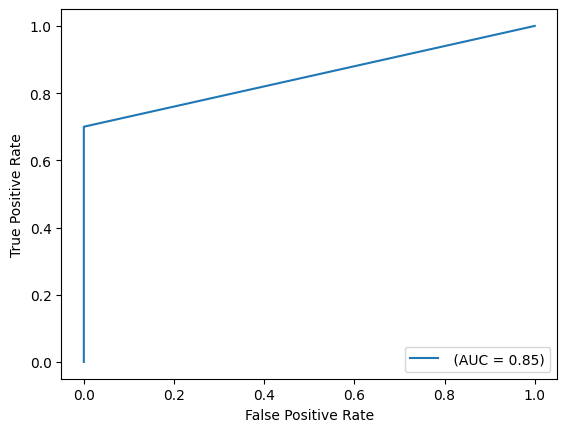

fpr=[0. 0. 1.], tpr=[0.  0.7 1. ]


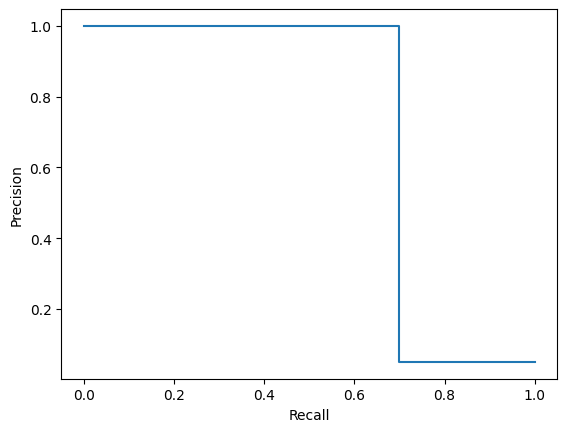

In [164]:
# print roc curve display
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='')
display.plot()
plt.show()

print(f"fpr={fpr}, tpr={tpr}")

# print prediction recall display
precision, recall, _ = precision_recall_curve(y_true, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

## What would happen if the number of false positive increases?

In this second scenario, we have a population with the following characteristics:


1. Number of possitive instances = 10
2. Total popultion size = 200
3. The prediction algorithm is able to estimate correctly 70% of the target values, having a recall=0.7.
4. Howeverl the precision this time is has gone low to a value of 0.259.

**Note**, the AUC score is still quite high, right? with a value of 0.797.

In [165]:
predefined_ones = sample_maybe_ones(number_of_ones=number_of_ones, default_size=default_size)
y_true = make_y_pred(default_size=default_size, ones_index=predefined_ones)
y_pred = make_y_pred(default_size=default_size, ones_index=predefined_ones[0:7], add_noice_for=20)

print_predictions(y_true=y_true, y_pred=y_pred)

{'precision': 0.296, 'recall': 0.8, 'f1': 0.432, 'accuracy': 0.895, 'auc_score': 0.85}


The ROC/AUC curve and the Precision-Recall curve can be seen in the following figures.

**Note**, the AUC curve looks very similar to the previous one, this should be always the case as the score has not change dramatically. However, the Precision-Recall curve is substantially lower and this is due to precision having tanked.

Seen the possible misundertanding of the AUC score without having more context about prcision/recall? For that second prediction, the results are bad, bad and all is due to the class inbalance.

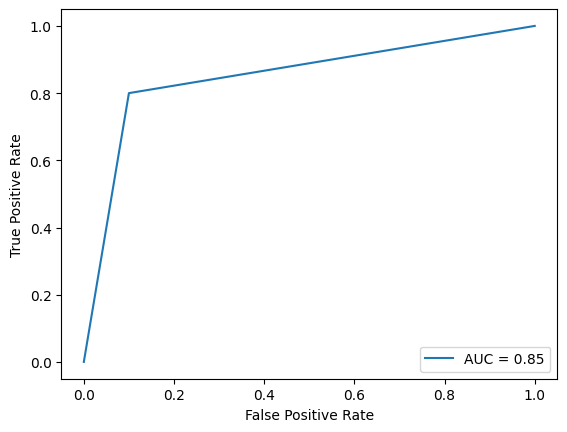

fpr=[0.  0.1 1. ], tpr=[0.  0.8 1. ]


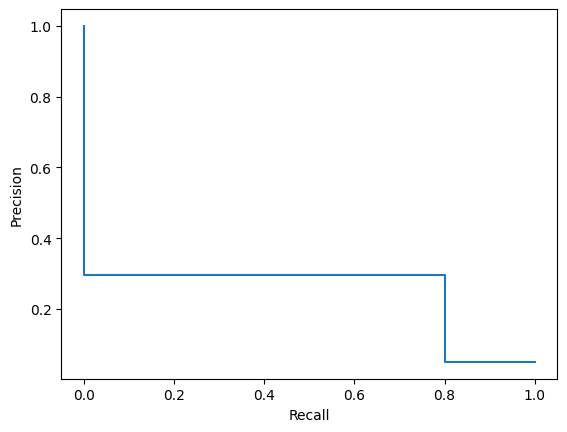

In [166]:
# print roc curve display
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.show()

print(f"fpr={fpr}, tpr={tpr}")

# print prediction recall display
precision, recall, _ = precision_recall_curve(y_true, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

## What would happen if the classes are balanced?

Lets repeat the process again, but this time with balanced classes.

In [167]:
number_of_ones = 100
default_size = 200

predefined_ones = sample_maybe_ones(number_of_ones=number_of_ones, default_size=default_size)
y_true = make_y_pred(default_size=default_size, ones_index=predefined_ones)
y_pred = make_y_pred(default_size=default_size, ones_index=predefined_ones[0:70], add_noice_for=0)

print_predictions(y_true=y_true, y_pred=y_pred)

{'precision': 1.0, 'recall': 0.7, 'f1': 0.823, 'accuracy': 0.85, 'auc_score': 0.85}


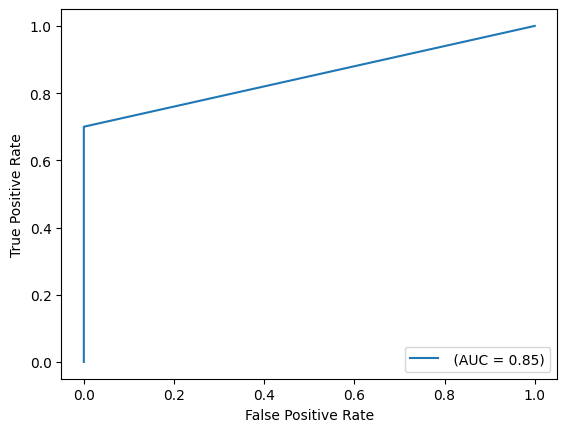

fpr=[0. 0. 1.], tpr=[0.  0.7 1. ]


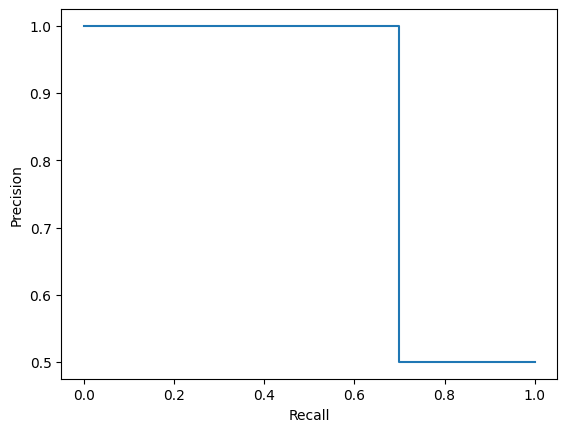

In [168]:
# print roc curve display
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='')
display.plot()
plt.show()

print(f"fpr={fpr}, tpr={tpr}")

# print prediction recall display
precision, recall, _ = precision_recall_curve(y_true, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

In [169]:
predefined_ones = sample_maybe_ones(number_of_ones=number_of_ones, default_size=default_size)
y_true = make_y_pred(default_size=default_size, ones_index=predefined_ones)
y_pred = make_y_pred(default_size=default_size, ones_index=predefined_ones[0:70], add_noice_for=20)

print_predictions(y_true=y_true, y_pred=y_pred)

{'precision': 0.844, 'recall': 0.76, 'f1': 0.8, 'accuracy': 0.81, 'auc_score': 0.81}


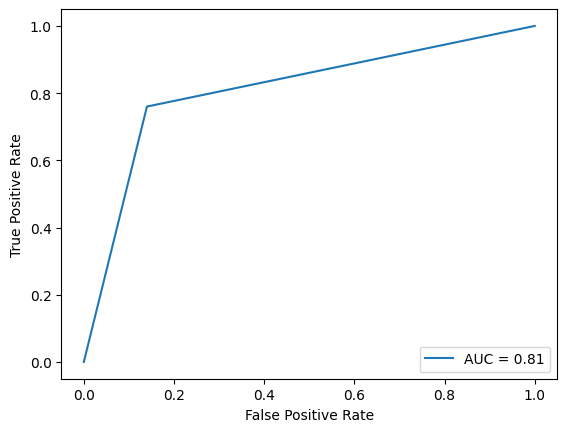

fpr=[0.   0.14 1.  ], tpr=[0.   0.76 1.  ]


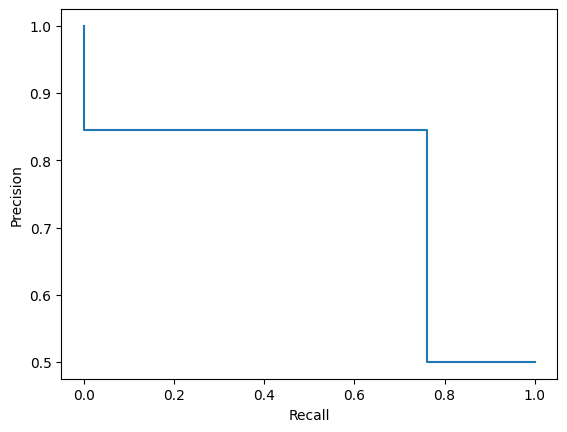

In [170]:
# print roc curve display
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.show()

print(f"fpr={fpr}, tpr={tpr}")

# print prediction recall display
precision, recall, _ = precision_recall_curve(y_true, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

As you can see in this sections example, now that the classes are balanced, the outcome even if the number of false positive increases, is keep reasonable informative of the model performance.

Next time, when you are evaluating your models, be aware of the need to provide context, otherwise metrics alone might lead to miss understanding and confusion.